**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *What is that tune? A classification method to identify song genres*

## Abstract

The goal of this report is to develop a method to identify the genres of a given list of songs. To develop this method, it is provided a dataset with different features of the songs, such as rhythm patterns, chroma, and values for the MFCCs. Consequently, it is followed by a workflow comprising three sections, preprocessing, modeling and results. These sections start by analyzing the data (Preprocessing), leaving it ready to apply the Machine Learning model (Modeling) and finally presenting the results obtained (Results). Through this process, different Machine Learning algorithms have been used to build the best solution. As a result, it is obtained an accuracy of 65% correct predictions in more than 6500 different songs with a log-loss of 0.17 by using Logistic Regression.

## 1. Introduction

Recommendation and discovery systems based on user preferences and activity have become increasingly popular across all different types of platforms, from retail (e.g. Amazon), to video (e.g. Netflix) and music (e.g. Spotify). These systems usually depend on a correct and precise categorization of products, which is not always something easy to achieve.

The purpose of this project is to design and develop a machine learning solution to identify the music genre of a song given a set of attributes that describe its timbre, pitch and rhythm. The resulting model should be able to group music into categories that can later be used for recommendation or discovery.

The problem of music genre classification is not an easy one because while the distinction between some genres is straightforward (e.g. heavy metal vs classical), others are harder to distinguish due to their similarity (e.g. rock vs blues).

To address this problem, we will be dividing the workflow into three main sections:
- **Preprocessing**: First, we will analyze the data provided and prepare it to be used by a machine learning algorithm.
- **Modeling**: Once the data is ready, we will define different machine learning algorithms and fit them into the the training dataset to obtain a classification model, which we will use to predict the labels of the test dataset.
- **Results**: Finally, we will upload the predicted labels of the test dataset to Kaggle, to have some feedback about the performance of our model. If the results are good, our job will be concluded. Otherwise, we will tune our model or select a new one and repeat the training process again.

In the image below we can see the subtasks of each step while having an overall image of the whole process.

![Diagram](img/diagram.svg)
![Diagramxx](img/diagram_01.png)

## 2. Data analysis

In this first part we will analyze the data and prepare it for the modeling phase. More specifically, we will look for data inconsistency, such as missing values (NA's), and highly correlated features, and we will standardize the data and reduce its dimensionality using Principal Component Analysis (PCA). After this whole process we will have a prepared dataset for the next phase (we will save this dataset in the **data_preprocessed** folder).

![Diagram_01](img/diagram_01.svg)

In [12]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [13]:
# Load the data and cleanup
train_data = pd.read_csv("data/train_data.csv", header=None)
test_data = pd.read_csv("data/test_data.csv", header=None)

train_labels = pd.read_csv("data/train_labels.csv", header=None)

Number of NA's in train_data dataset: 0
Number of features: 264


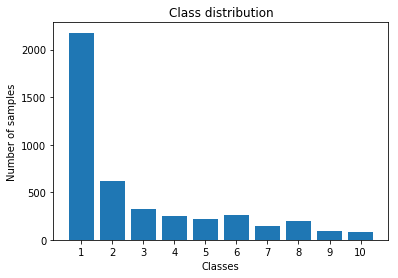

Number of NA's in correlation matrix: 2096
The first 78 components explain 90.19 % of the variance


In [14]:
#Analysis of the input data

# Are there any NA's?
print("Number of NA's in train_data dataset:" ,train_data.isna().sum().sum()) # 0 NA's

# Number of features
print("Number of features:", train_data.shape[1])

# Class distribution
labels = train_labels.loc[:,0].values
values = np.zeros(10)
for i in np.arange(1,11):
    count = 0
    for j in range(labels.shape[0]):
        if labels[j] == i :
            count += 1
    values[i-1] = count
plt.bar(np.arange(1,11), values)
plt.xticks(np.arange(1,11))
plt.title("Class distribution")
plt.xlabel("Classes")
plt.ylabel("Number of samples")
plt.show()
# As it can be seen on the graph, the majority of the samples belong to class 1
# (Pop_Rock). This imbalance on the data will create a model that is really good
# in indentifying samples that belong to this class.

# Correlation matrix
corr_mat = train_data.corr()

# Are there any NA's in the correlation matrix?
print("Number of NA's in correlation matrix:", corr_mat.isna().sum().sum()) # 2,096 NA's

# There are NA's in the correlation matrix which means there are features with
# no deviation (std = 0).
std = np.zeros(train_data.shape[1]) # Collect the std of each feature
for j in range(train_data.shape[1]):
    std[j] = np.std(train_data.loc[:,j].values)

std_0 = np.where(std < 1e-3)[0] # Features 216, 217, 218, 219

def remove_feat(df, feat):
    # INPUT: Dataframe df, array of features indexes to remove.
    # OUTPUT: Dataframe df without dropped features.
    
    num_remaining_feat = df.shape[1] - feat.shape[0]
    df.drop(df.columns[feat], axis=1, inplace=True)
    # Reasign index
    df.columns = np.arange(0, num_remaining_feat)

    return df

# Remove features with std = 0 since they have the same value for all the
# samples and thus do not provide any differential information.
train_data = remove_feat(train_data, std_0)
test_data = remove_feat(test_data, std_0)

# We recalculate the correlation matrix with the remaining features
corr_mat = train_data.corr()

# Find highly correlated features
high_corr_feat = [] # Collect highly correlated features
for j in range(1, corr_mat.shape[1]):
    for i in range(0, j):
        if np.abs(corr_mat.loc[i,j]) > 0.9:
            high_corr_feat.append(j)
            break
high_corr_feat = np.array(high_corr_feat) # List to array

# Remove high correlated features.
train_data = remove_feat(train_data, high_corr_feat)
test_data = remove_feat(test_data, high_corr_feat)

# The number of features has been reduced down to
num_feat = train_data.shape[1] # 193 features

# Standardize data
train_data_scaled = StandardScaler().fit_transform(train_data)
test_data_scaled = StandardScaler().fit_transform(test_data)

# PCA
pca = PCA(0.9)
pca.fit(train_data_scaled)
n_components = pca.n_components_
explained_variance = np.round(np.sum(pca.explained_variance_ratio_) * 100, 2)
print("The first", n_components, "components explain", explained_variance, "% of the variance")

train_data_pca = pca.transform(train_data_scaled)
test_data_pca = pca.transform(test_data_scaled)

# Convert transformed data to dataframe
train_data_final = pd.DataFrame(data=train_data_pca)
test_data_final = pd.DataFrame(data=test_data_pca)

# Save the final datasets.
train_data_final.to_csv("data_preprocessed/train_data.csv", index=False)
test_data_final.to_csv("data_preprocessed/test_data.csv", index=False)

*Summary:*

- No NA's values were found in the dataset.
- We removed 4 feautures that presented exactly the same value for all the samples and, therfore, did not provide any useful information to distinguish the genres.
- We removed several features that were highly correlated, that is, that presented a correlation above 0.9 or below -0.9.
- We analyzed the distribution of the labels and found that genre 1 (Pop_Rock) is the most dominant of the dataset. This creates an imbalance that will make the classification model be very good at identifying samples that belong to this class. (More comments about this imbalance in **Discussion/Conclusions** section).
- We applied PCA and reduced the number of variables to 78 while still explaining 90.19% of the variability.

## 3. Methods and experiments

Once the data has been preprocessed, we start applying different algorithmic models to it. We fit the model to the provided training set and we use it to predict the test data. Once we have the predictions, we export them to a *.csv* file inside the **output** folder and we upload them to Kaggle to test them.

As this is a classification problem, we have decided to use three different machine learning algorithms:
- Logistic regression
- Random forest
- Support Vector Machine

![Diagram_02](img/diagram_02.svg)

In [15]:
# Load pre-processed data
train_data = pd.read_csv("data_preprocessed/train_data.csv")
test_data = pd.read_csv("data_preprocessed/test_data.csv")

# Import train labels
train_labels = pd.read_csv("data/train_labels.csv", header=None)

# Transform dataframes to arrays so that they can be fed to the models.
X_train = train_data.values
X_test = test_data.values
y_train = train_labels.values

In [16]:
# MODEL-1: Logistic Regression

# Import library
from sklearn.linear_model import LogisticRegression

# Configure and apply model
model_1 = LogisticRegression(random_state=0, solver="lbfgs", multi_class="multinomial")
model_1.fit(X_train, y_train)
y_test = model_1.predict(X_test)
y_test_prob = model_1.predict_proba(X_test)

# Output files

n_samples = y_test.shape[0]

# Accuracy
out_array = np.zeros([n_samples, 2])
out_df = pd.DataFrame(data=out_array, columns=["Sample_id", "Sample_label"])
out_df["Sample_id"] = np.arange(1, n_samples + 1)
out_df["Sample_label"] = y_test
out_df.to_csv("output/logistic_regression.csv", index=False)

# Probabilities
out_array = np.zeros([n_samples, 11])
columns = ["Sample_id"]
for i in np.arange(1,11):
    columns.append("Class_" + str(i))
out_df = pd.DataFrame(data=out_array, columns=columns)
out_df["Sample_id"] = np.arange(1, n_samples + 1)
for j in np.arange(1,11):
    out_df[columns[j]] = y_test_prob[:,j-1]
out_df.to_csv("output/logistic_regression_prob.csv", index=False)

/home/jaime/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
# MODEL-2: Random Forest

from sklearn.ensemble import RandomForestClassifier

# Configure and apply model
model_2 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
model_2.fit(X_train, y_train)
y_test = model_2.predict(X_test)
y_test_prob = model_2.predict_proba(X_test)

# Output files

n_samples = y_test.shape[0]

# Accuracy
out_array = np.zeros([n_samples, 2])
out_df = pd.DataFrame(data=out_array, columns=["Sample_id", "Sample_label"])
out_df["Sample_id"] = np.arange(1, n_samples + 1)
out_df["Sample_label"] = y_test
out_df.to_csv("output/random_forest.csv", index=False)

# Probabilities
out_array = np.zeros([n_samples, 11])
columns = ["Sample_id"]
for i in np.arange(1,11):
    columns.append("Class_" + str(i))
out_df = pd.DataFrame(data=out_array, columns=columns)
out_df["Sample_id"] = np.arange(1, n_samples + 1)
for j in np.arange(1,11):
    out_df[columns[j]] = y_test_prob[:,j-1]
out_df.to_csv("output/random_forest_prob.csv", index=False)

/home/jaime/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


In [18]:
# MODEL-3: Support Vector Machine

from sklearn.svm import SVC

# Configure and apply model
model_3 = SVC(gamma="auto", probability=True)
model_3.fit(X_train, y_train)
y_test = model_3.predict(X_test)
y_test_prob = model_3.predict_proba(X_test)

# Output files

n_samples = y_test.shape[0]

# Accuracy
out_array = np.zeros([n_samples, 2])
out_df = pd.DataFrame(data=out_array, columns=["Sample_id", "Sample_label"])
out_df["Sample_id"] = np.arange(1, n_samples + 1)
out_df["Sample_label"] = y_test
out_df.to_csv("output/svm.csv", index=False)

# Probabilities
out_array = np.zeros([n_samples, 11])
columns = ["Sample_id"]
for i in np.arange(1,11):
    columns.append("Class_" + str(i))
out_df = pd.DataFrame(data=out_array, columns=columns)
out_df["Sample_id"] = np.arange(1, n_samples + 1)
for j in np.arange(1,11):
    out_df[columns[j]] = y_test_prob[:,j-1]
out_df.to_csv("output/svm_prob.csv", index=False)

/home/jaime/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 4. Results

Finally, we upload to Kaggle the results obtained after applying the different models to obtain the accuracy and the log-loss of the test dataset, and we compare these metrics with those of the train dataset. We compute also a confusion matrix of the train dataset for each of the models to analyze what wrong classifications were the most frequent.

![Diagram_03](img/diagram_03.svg)

In [19]:
# Performance on test data
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def get_metrics(model):
    # INPUT: trained model
    # OUTPUT: printed accuracy and log-loss, return predicted labels for the training set
    
    y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    loss = log_loss(y_train, y_pred_proba)
    print("accuracy:", accuracy)
    print("log-loss:", loss)
    return y_pred

print("Logistic Regression:")
y_pred_1 = get_metrics(model_1)
print("Random Forest:")
y_pred_2 = get_metrics(model_2)
print("SVM:")
y_pred_3 = get_metrics(model_3)

Logistic Regression:
accuracy: 0.6903506761402705
log-loss: 0.9501429470921838
Random Forest:
accuracy: 1.0
log-loss: 0.27177420130372626
SVM:
accuracy: 0.856062342424937
log-loss: 0.37591332054377385


In [20]:
# Confussion matrix
from sklearn.metrics import confusion_matrix
def get_confussion_matrix(y_pred):
    print(confusion_matrix(y_train, y_pred))
print("Logistic Regression:")
get_confussion_matrix(y_pred_1)
print("Random Forest:")
get_confussion_matrix(y_pred_2)
print("SVM:")
get_confussion_matrix(y_pred_3)

Logistic Regression:
[[1948  100   19   27   19   33    4   23    4    1]
 [ 169  393   20   16    4    8    1    2    4    1]
 [  42   18  240    3    3   12    1    0    7    0]
 [  80   14    5  136    4   11    1    0    0    2]
 [ 104   11    8   11   56    8    4    7    5    0]
 [  97   11   21   13    7  102    0    3    1    5]
 [  80   11    5    8    7    3   12    5    4    6]
 [ 121    1    1    2    3    3    2   62    0    0]
 [  10    5   15    1    3    7    0    0   51    0]
 [  45    1    2   12    4    2    1    7    0   12]]
Random Forest:
[[2178    0    0    0    0    0    0    0    0    0]
 [   0  618    0    0    0    0    0    0    0    0]
 [   0    0  326    0    0    0    0    0    0    0]
 [   0    0    0  253    0    0    0    0    0    0]
 [   0    0    0    0  214    0    0    0    0    0]
 [   0    0    0    0    0  260    0    0    0    0]
 [   0    0    0    0    0    0  141    0    0    0]
 [   0    0    0    0    0    0    0  195    0    0]
 [   0   

The results using the different models are:

| Model | Test Acc. | Test Log-Loss | Train Acc. | Train Log-Loss |
|-------|-----------|---------------|------------|----------------|
| Logistic Regression | 0.65613 | 0.17826 | 0.69035 | 0.95014 |
| Random Forest | 0.56597 | 0.21974 | 1 | 0.27177 |
| Support Vector Machine | 0.62200 | 0.17637 | 0.85606 | 0.37716 |

## 5. Discussion/Conclusions

After analyzing the performance of the three models on both the train and the test data, it is worth highlighting that:

- The logistic regression model has the best overall performance, as it has the best test accuracy (0.65613) and a slightly superior log-loss (0.17826) than the SVM model (0.17637).
- The random forest model is overfitted, as its accuracy on the training set is way higher (1) than the one obtained for the test set (0.56597).
- The SVM model is also slightly overfitted, as its accuracy on the training set is higher (0.85606) than the one obtained for the test set (0.62200).

As it was mentioned in the **Data analysis** section, the imbalance in the dataset caused by the great amount of samples that belong to class 1 (Pop_Rock) creates an algorithm that is biased in favor of class 1, that is, that will be more likely to classify samples as class 1. This can be easily seen by analyzing the confusion matrices - in all three cases, the values of the first column are greater than the values of the first row. To mitigate this effect, we decided to remove several samples from the training set that belonged to class 1. However, the performance on the test set dropped down when doing this. One possible explanation is that a big majority of songs belong to the Pop_Rock genre (class 1) and, therefore, a biased model towards this class will have better odds of correctly labeling samples.

Even though the performance obtained by our best model is not outstanding, we are very close to Kaggle's best accuracy (0,01936 difference) and best log-loss (0,01163 difference).

We believe that future improvements on the classification of music genre will come from increasing the number of samples and using complex neural networks, which continuously improve its performance as the number of samples increases.

Finally, we can conclude that our project have managed to identify the music genre of the different samples, but the accuracy is far from good. Future improvements will be needed to create a system that is really realiable.

## 6. References

- Scikit Learn. Logistic Regression. http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Scikit Learn. Random Forest. http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- Scikit Learn. SVC. http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html